## Part IV.4: Baseline Linear Regression Model using Only Deterioration Index Feature

In this section, experiments were conducted to train a baseline linear regression classifier model with only the Deterioration Index as a feature.

Objectives are:
1.  Establish baseline performance metrics with a simple model
2.  Determine if DI provides sufficient predictive power to further reduce feature count

In [1]:
import sys
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
import matplotlib.pyplot as plt

# Add the directory containing `sepsis_helpers.py` to the Python path
helper_file_path = "/content/sepsis_helpers.py"  # Replace with the correct directory path if different
sys.path.append(helper_file_path)

In [2]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, ConfusionMatrixDisplay, confusion_matrix

In [3]:
LOAD_FROM_GDRIVE = True

In [4]:
if(LOAD_FROM_GDRIVE):
    # mount google drive to load data
    from google.colab import drive
    drive.mount('/content/drive')

    dataset_root = '/content/drive/MyDrive/Colab Notebooks/sepsis clean dataset/'

    X_train = np.load(os.path.join(dataset_root, 'X_train.npy'))
    y_train = np.load(os.path.join(dataset_root, 'y_train.npy'))

    X_test = np.load(os.path.join(dataset_root, 'X_test.npy'))
    y_test = np.load(os.path.join(dataset_root, 'y_test.npy'))

    X_val =  np.load(os.path.join(dataset_root, 'X_val.npy'))
    y_val = np.load(os.path.join(dataset_root, 'y_val.npy'))

else:
    # load from datalake (S3)
    !aws s3 cp $s3_datalake_path_prepared $local_data_path_csv --recursive --exclude "*" --include "*.npy"

    X_train = np.load(os.path.join(local_data_path_csv, 'X_train.npy'))
    y_train = np.load(os.path.join(local_data_path_csv, 'y_train.npy'))

    X_test = np.load(os.path.join(local_data_path_csv, 'X_test.npy'))
    y_test = np.load(os.path.join(local_data_path_csv, 'y_test.npy'))

    X_val =  np.load(os.path.join(local_data_path_csv, 'X_val.npy'))
    y_val = np.load(os.path.join(local_data_path_csv, 'y_val.npy'))

Mounted at /content/drive


In [5]:
# inspect the loaded data
print(f"Train data shape: X: {X_train.shape}, y: {y_train.shape}")
print(f"Test data shape: X: {X_test.shape}, y: {y_test.shape}")
print(f"Validation data shape: X: {X_val.shape}, y: {y_val.shape}")

Train data shape: X: (3105, 48, 51), y: (3105,)
Test data shape: X: (388, 48, 51), y: (388,)
Validation data shape: X: (389, 48, 51), y: (389,)


In [6]:
 # Import the DeteriorationIndex class
from sepsis_helpers import DeteriorationIndex

In [21]:
# Debugging adjustments in compute_deterioration_index
def compute_deterioration_index(data):
    indices = []
    for patient in data:
        # Print shape of patient for debugging
        print(f"Original patient shape: {patient.shape}")

        # Extract relevant features for the patient
        patient_relevant = patient[:, relevant_indices]
        print(f"Shape after feature selection: {patient_relevant.shape}")

        # Explicitly reshape and transpose to ensure correct orientation
        patient_relevant = np.transpose(patient_relevant)  # Transpose to (48, 10)
        print(f"Shape after transpose: {patient_relevant.shape}")

        # Validate shape before proceeding
        assert patient_relevant.shape == (48, len(relevant_columns)), f"Shape mismatch: {patient_relevant.shape}"

        # Create a DataFrame for the patient
        patient_df = pd.DataFrame(patient_relevant, columns=relevant_columns)

        # Calculate deterioration index for the patient
        di_calculator = DeteriorationIndex(patient_df)
        indices.append(di_calculator.patient_full_deterioration_index())
    return np.array(indices)

# Re-run the Deterioration Index computation
try:
    deterioration_index_train = compute_deterioration_index(X_train)
    deterioration_index_val = compute_deterioration_index(X_val)
except AssertionError as e:
    print(e)

Original patient shape: (48, 51)
Shape after feature selection: (48, 10)
Shape after transpose: (10, 48)
Shape mismatch: (10, 48)


In [22]:
# Adjusted function to compute Deterioration Index for all patients
def compute_deterioration_index(data):
    indices = []
    for patient in data:
        # Print shape of patient for debugging
        print(f"Original patient shape: {patient.shape}")

        # Extract relevant features for the patient
        patient_relevant = patient[:, relevant_indices]
        print(f"Shape after feature selection: {patient_relevant.shape}")

        # Validate shape before proceeding
        assert patient_relevant.shape == (48, len(relevant_columns)), f"Shape mismatch: {patient_relevant.shape}"

        # Create a DataFrame for the patient
        patient_df = pd.DataFrame(patient_relevant, columns=relevant_columns)

        # Calculate deterioration index for the patient
        di_calculator = DeteriorationIndex(patient_df)
        indices.append(di_calculator.patient_full_deterioration_index())
    return np.array(indices)

# Re-run the Deterioration Index computation
deterioration_index_train = compute_deterioration_index(X_train)
deterioration_index_val = compute_deterioration_index(X_val)

# Flatten the original feature arrays and add the deterioration index
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

X_train_with_di = np.hstack((X_train_flat, deterioration_index_train))
X_val_with_di = np.hstack((X_val_flat, deterioration_index_val))


Streaming output truncated to the last 5000 lines.
Original patient shape: (48, 51)
Shape after feature selection: (48, 10)
Original patient shape: (48, 51)
Shape after feature selection: (48, 10)
Original patient shape: (48, 51)
Shape after feature selection: (48, 10)
Original patient shape: (48, 51)
Shape after feature selection: (48, 10)
Original patient shape: (48, 51)
Shape after feature selection: (48, 10)
Original patient shape: (48, 51)
Shape after feature selection: (48, 10)
Original patient shape: (48, 51)
Shape after feature selection: (48, 10)
Original patient shape: (48, 51)
Shape after feature selection: (48, 10)
Original patient shape: (48, 51)
Shape after feature selection: (48, 10)
Original patient shape: (48, 51)
Shape after feature selection: (48, 10)
Original patient shape: (48, 51)
Shape after feature selection: (48, 10)
Original patient shape: (48, 51)
Shape after feature selection: (48, 10)
Original patient shape: (48, 51)
Shape after feature selection: (48, 10)


In [23]:
print(deterioration_index_train.shape)  # Should output (3105, 48)
print(X_train_with_di.shape)           # Should output (3105, original_features_flattened + 48)

(3105, 48)
(3105, 2496)


In [24]:
print(deterioration_index_train[0])  # Should contain 48 time-step scores for the first patient

[1.12 1.12 1.12 1.12 1.12 1.12 1.12 1.12 1.12 1.12 1.12 1.12 1.12 1.12
 1.12 1.12 1.12 1.12 1.12 1.12 1.12 1.12 1.12 1.12 1.12 1.12 1.12 1.12
 1.12 1.12 1.12 1.12 1.12 1.12 1.12 1.12 1.12 1.12 1.12 1.12 1.12 1.12
 1.12 1.12 1.12 1.12 1.12 1.12]


In [25]:
print(np.std(deterioration_index_train, axis=1))  # Standard deviation for each patient's time steps


[0.         0.         0.         ... 0.         0.06366153 0.        ]


Analysis:

Mostly Zero Values: Many patients have a deterioration index that does not vary across time steps, likely because their input features are stable or the scoring method in DeteriorationIndex does not account for changes.
Non-Zero Variation: A few patients, like the one with a standard deviation of 0.06366153, exhibit slight variability, suggesting their features or scores fluctuate over time

In [27]:
# Train Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_with_di, y_train)

# Make predictions
y_val_pred = linear_model.predict(X_val_with_di)
y_val_pred_binary = (y_val_pred >= 0.5).astype(int)



In [28]:
# Calculate Metrics
binary_accuracy = accuracy_score(y_val, y_val_pred_binary)
precision = precision_score(y_val, y_val_pred_binary)
recall = recall_score(y_val, y_val_pred_binary)

print(f"Binary Accuracy: {binary_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")



Binary Accuracy: 0.7404
Precision: 0.4949
Recall: 0.4900


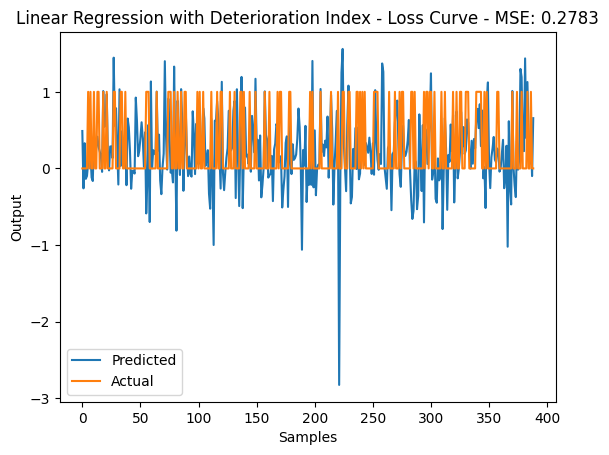

In [29]:
# Loss Curve
def plot_loss(y_true, y_pred, title="Loss Curve"):
    mse = mean_squared_error(y_true, y_pred)
    plt.plot(y_pred, label="Predicted")
    plt.plot(y_true, label="Actual")
    plt.title(f"{title} - MSE: {mse:.4f}")
    plt.xlabel("Samples")
    plt.ylabel("Output")
    plt.legend()
    plt.show()

plot_loss(y_val, y_val_pred, title="Linear Regression with Deterioration Index - Loss Curve")



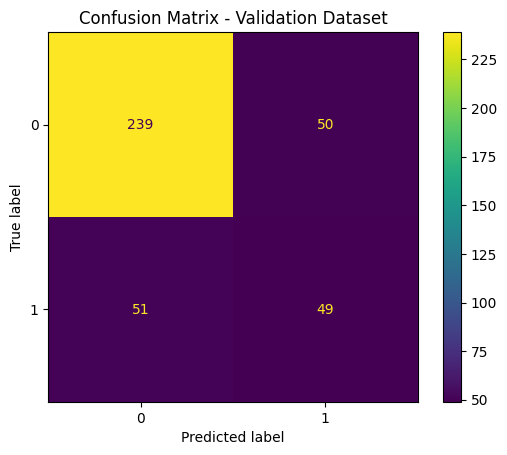

In [30]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - Validation Dataset")
plt.show()

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

# Compute Loss
loss = mean_squared_error(y_val, y_val_pred)

# Compute Metrics
binary_accuracy = accuracy_score(y_val, y_val_pred_binary)
precision = precision_score(y_val, y_val_pred_binary)
recall = recall_score(y_val, y_val_pred_binary)
f1 = f1_score(y_val, y_val_pred_binary)

# Collect Results
results = [loss, binary_accuracy, precision, recall, f1]

# Print Results
print(f"Loss: {results[0]:.4f}")
print(f"Binary Accuracy: {results[1]:.4f}")
print(f"Precision: {results[2]:.4f}")
print(f"Recall: {results[3]:.4f}")
print(f"F1 Score: {results[4]:.4f}")


Loss: 0.2783
Binary Accuracy: 0.7404
Precision: 0.4949
Recall: 0.4900
F1 Score: 0.4925
